In [1]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
#Prepare Data


df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")
ts = df["traffic_volume"].asfreq("H").fillna(method="ffill").values.reshape(-1,1)

# Scale values (0-1 range helps NN training)
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)

# Train-test split
train_size = int(len(ts_scaled) * 0.8)
train, test = ts_scaled[:train_size], ts_scaled[train_size:]

C:\Users\Yvonne\AppData\Local\Temp\ipykernel_5784\722117426.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df["traffic_volume"].asfreq("H").fillna(method="ffill").values.reshape(-1,1)
C:\Users\Yvonne\AppData\Local\Temp\ipykernel_5784\722117426.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = df["traffic_volume"].asfreq("H").fillna(method="ffill").values.reshape(-1,1)


In [ ]:
# Create supervised sequences
def create_sequences(data, window=24):
    #Input = past 24 hours; Output = next hour
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window]) # 24-hour history
        y.append(data[i+window]) # predict next hour
    return np.array(X), np.array(y)

window_size = 24  # look back 24 hours to predict next hour
X_train, y_train = create_sequences(train, window_size)
X_test, y_test = create_sequences(test, window_size)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (48456, 24, 1) (48456, 1)
Test shape: (12096, 24, 1) (12096, 1)


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation="tanh", input_shape=(window_size, 1)),
    Dense(1)
])
#64 hidden units
#dense(1) output = regression

model.compile(optimizer="adam", loss="mse")
#Optimizer = Adam (adaptive learning rate)

c:\Users\Yvonne\Desktop\DATA SCIENCE\advanced ml\traffic_flow_forecast\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train model
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
#Stops early if validation loss doesn’t improve after 3 epochs

history = model.fit(
    X_train, y_train,
    validation_split=0.1, #10% validation
    epochs=20,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 2/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 3/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 4/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 7/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 62s 32ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 11/20
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 12

In [ ]:
# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

#Model outputs predictions in scaled space
#must inverse transform back to original traffic volume

y_test_rescaled = scaler.inverse_transform(y_test)

378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [7]:
#Evaluate
mse = mean_squared_error(y_test_rescaled, y_pred)
mae = mean_absolute_error(y_test_rescaled, y_pred)
r2 = r2_score(y_test_rescaled, y_pred)

print(f"LSTM -> MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

LSTM -> MSE: 45713.98, MAE: 100.34, R2: 0.9798


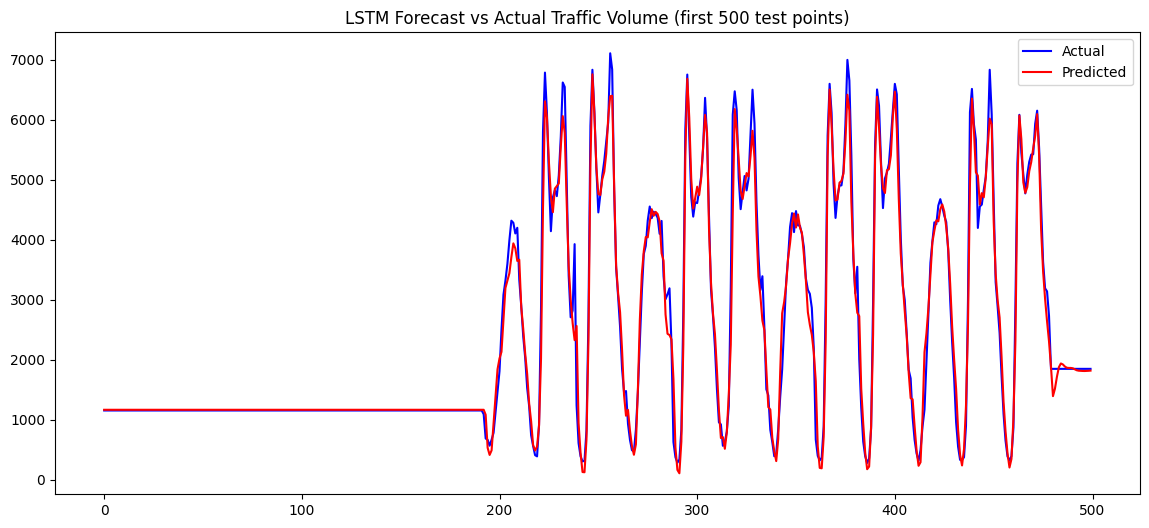

In [8]:
#Plot Actual vs Predicted

plt.figure(figsize=(14,6))
plt.plot(y_test_rescaled[:500], label="Actual", color="blue")
plt.plot(y_pred[:500], label="Predicted", color="red")
plt.legend()
plt.title("LSTM Forecast vs Actual Traffic Volume (first 500 test points)")
plt.show()

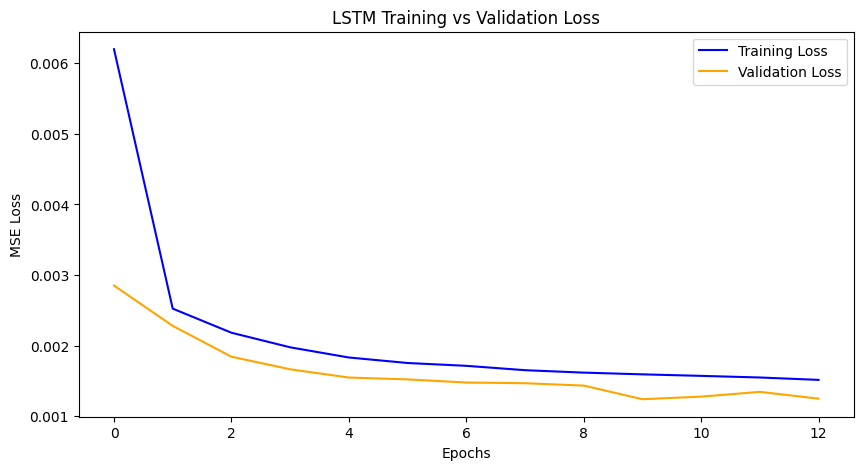

In [9]:
# Plot training & validation loss curves
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label="Training Loss", color="blue")
plt.plot(history.history['val_loss'], label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.show()